# Abundance Matching

### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from tqdm import trange
import pymc3 as pm
import theano
import theano.tensor as tt


%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will 

## Datos

#### Bouwens

<img src="https://cdn.mathpix.com/snip/images/WTuNW8HreMYZDdZBvWGW1rW9nSD4COOjsfjqS6Xq3aY.original.fullsize.png" />

In [ ]:
z4 =[
"-22.69,0.000003,0.000004",
"-22.19,0.000015,0.000009",
"-21.69,0.000134,0.000023",
"-21.19,0.000393,0.000040",
"-20.69,0.000678,0.000063",
"-20.19,0.001696,0.000113",
"-19.69,0.002475,0.000185",
"-19.19,0.002984,0.000255",
"-18.69,0.005352,0.000446",
"-18.19,0.006865,0.001043",
"-17.69,0.010473,0.002229",
"-16.94,0.024580,0.003500",
"-15.94,0.025080,0.007860"]



z5 = [
"-23.11,0.000002,0.000002",
"-22.61,0.000006,0.000003",
"-22.11,0.000034,0.000008",
"-21.61,0.000101,0.000014",
"-21.11,0.000265,0.000025",
"-20.61,0.000676,0.000046",
"-20.11,0.001029,0.000067",
"-19.61,0.001329,0.000094",
"-19.11,0.002085,0.000171",
"-18.36,0.004460,0.000540",
"-17.36,0.008600,0.001760",
"-16.36,0.024400,0.007160",
]

z6 = [
"-22.52,0.000002,0.000002",
"-22.02,0.000015,0.000006",
"-21.52,0.000053,0.000012",
"-21.02,0.000176,0.000025",
"-20.52,0.000320,0.000041",
"-20.02,0.000698,0.000083",
"-19.52,0.001246,0.000137",
"-18.77,0.001900,0.000320",
"-17.77,0.006680,0.001380",
"-16.77,0.013640,0.004200"
]

w = open('Bouwens 2015/bowensz4.csv','w')
for l in z4:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz5.csv','w')
for l in z5:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz6.csv','w')
for l in z6:
    w.write(l+'\n')
w.close()

In [2]:
bw_z4 = pd.read_csv("Bouwens 2015/bowensz4.csv", names=['M','phi','err_phi']) 
bw_z4['Mass'] = np.log10(120 * np.power(10,-0.4 * (bw_z4.M.values - 4.62)))
bw_z5 = pd.read_csv("Bouwens 2015/bowensz5.csv", names=['M','phi','err_phi']) 
bw_z5['Mass'] = np.log10(120 * np.power(10,-0.4 * (bw_z5.M.values - 4.62)))
bw_z6 = pd.read_csv("Bouwens 2015/bowensz6.csv", names=['M','phi','err_phi']) 
bw_z6['Mass'] = np.log10(120 * np.power(10,-0.4 * (bw_z6.M.values - 4.62)))

In [14]:
bw_z4

,M,phi,err_phi,Mass,#UV_Center
0,-22.69,0.000003,0.000004,13.003181,-22.75
1,-22.19,0.000015,0.000009,12.803181,-22.25
2,-21.69,0.000134,0.000023,12.603181,-21.75
3,-21.19,0.000393,0.000040,12.403181,-21.25
4,-20.69,0.000678,0.000063,12.203181,-20.75
5,-20.19,0.001696,0.000113,12.003181,-20.25
6,-19.69,0.002475,0.000185,11.803181,-19.75
7,-19.19,0.002984,0.000255,11.603181,-19.25
8,-18.69,0.005352,0.000446,11.403181,-18.75
9,-18.19,0.006865,0.001043,11.203181,-18.25


#### Behroozi 2019

In [3]:
hmf_z4=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.202435.dat", skiprows=2,sep="\s")

hmf_z5=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.166998.dat", skiprows=2,sep="\s")

hmf_z6=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.141685.dat", skiprows=2,sep="\s")

uvsm_z4=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z3.5-z4.5.dat", skiprows=3,sep="\s")

uvsm_z5=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z4.5-z5.5.dat", skiprows=3,sep="\s")

uvsm_z6=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z5.5-z6.5.dat", skiprows=3,sep="\s")

smhm_z4=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.202435.dat", skiprows=6,sep="\s")
smhm_z5=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.166998.dat", skiprows=6,sep="\s")
smhm_z6=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.141685.dat", skiprows=6,sep="\s")

C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not s

In [4]:
print(smhm_z6.columns.values)

smhm_z4.insert(7,'Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values - np.log10(0.016)))
smhm_z4.insert(8,'Err+Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values + smhm_z4['Err+(5)'].values - np.log10(0.016)))
smhm_z4.insert(9,'Err-Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values - smhm_z4['Err-(6)'].values - np.log10(0.016)))
smhm_z4[smhm_z4['Log_SMHM(4)'] == 0] = 0

smhm_z5.insert(7,'Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values - np.log10(0.016)))
smhm_z5.insert(8,'Err+Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values + smhm_z5['Err+(5)'].values - np.log10(0.016)))
smhm_z5.insert(9,'Err-Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values - smhm_z5['Err-(6)'].values - np.log10(0.016)))
smhm_z5[smhm_z5['Log_SMHM(4)'] == 0] = 0


smhm_z6.insert(7,'Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values - np.log10(0.016)))
smhm_z6.insert(8,'Err+Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values + smhm_z6['Err+(5)'].values - np.log10(0.016)))
smhm_z6.insert(9,'Err-Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values - smhm_z6['Err-(6)'].values - np.log10(0.016)))
smhm_z6[smhm_z6['Log_SMHM(4)'] == 0] = 0

['#Log10(HM_Center)(0)' 'Log_SM(1)' 'Err+(2)' 'Err-(3)' 'Log_SMHM(4)'
 'Err+(5)' 'Err-(6)' 'Log_True_SM(7)' 'Err+(8)' 'Err-(9)'
 'Log_True_SMHM(10)' 'Err+(11)' 'Err-(12)' 'HM_Left_Edge(13)'
 'HM_Right_Edge(14)' 'Bestfit_Halo_Counts(15)']


In [5]:
smhm_z6['Q*']

0     0.000000
1     0.000000
2     0.000000
3     0.000875
4     0.001617
5     0.002730
6     0.006384
7     0.019131
8     0.038818
9     0.059985
10    0.086067
11    0.126289
12    0.183072
13    0.266217
14    0.387399
15    0.564852
16    0.811344
17    0.779394
18    0.253627
19    0.170160
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
Name: Q*, dtype: float64

### Conversion UV SM

In [7]:
archivos = ["HMFCalc/Seth_WMAP7/mVector_z=4 .txt","HMFCalc/Seth_WMAP7/mVector_z=5 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=6 .txt","HMFCalc/Seth_WMAP7/mVector_z=7 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=8 .txt"]
'''
archivos2 = ["HMFCalc/Seth_Planck/mVector_PLANCK-SMT z4 .txt","HMFCalc/Seth_Planck/mVector_PLANCK-SMT z5 .txt",
           "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z6 .txt","HMFCalc/Seth_Planck/mVector_PLANCK-SMT z7 .txt",
           "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z8 .txt"]
'''
archivos2 = ["HMFCalc/Beh-Planck/mVector_PLANCK- z = 4 .txt","HMFCalc/Beh-Planck/mVector_PLANCK- z = 5 .txt",
           "HMFCalc/Beh-Planck/mVector_PLANCK- z = 6 .txt","HMFCalc/Beh-Planck/mVector_PLANCK- z = 7 .txt",
           "HMFCalc/Beh-Planck/mVector_PLANCK- z = 8 .txt"]
hmfcalc_list=[]
hmfcalc_list2=[]

for i in range(3):
    a = archivos[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12)
    hmfcalc_z = hmfcalc_z.iloc[:,[0,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values)
    hmfcalc_list.append(hmfcalc_z)
    
    a = archivos2[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12)
    hmfcalc_z = hmfcalc_z.iloc[:,[0,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values)
    hmfcalc_list2.append(hmfcalc_z)

C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
C:\Users\santiago.arranz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


### Puntos Steinhardt

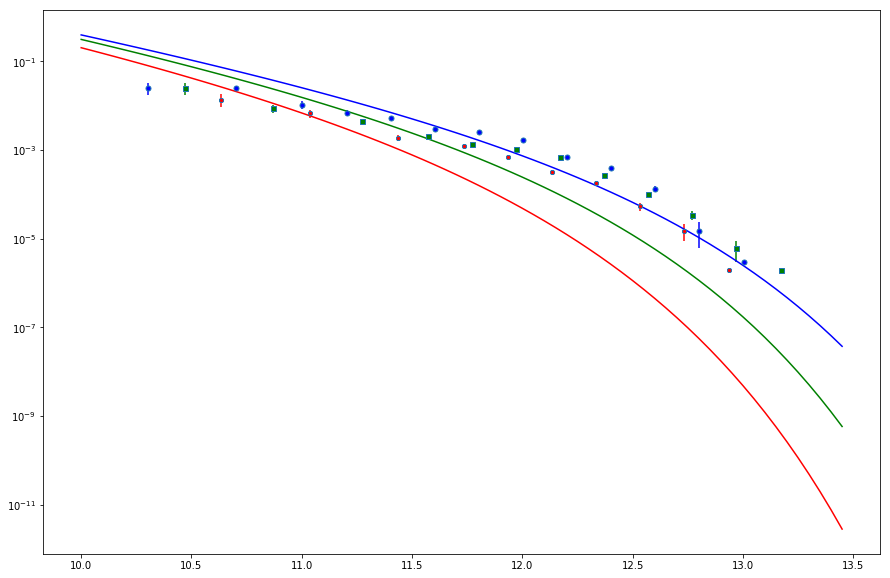

In [8]:
plt.figure(figsize=(15,10))
plt.errorbar(bw_z4.Mass,bw_z4.phi, bw_z4.err_phi,marker='o',ms=5, mfc='b',ecolor="b",linestyle="")
plt.errorbar(bw_z5.Mass,bw_z5.phi, bw_z5.err_phi,marker='s',ms=5, mfc='g',ecolor="g",linestyle="")
plt.errorbar(bw_z6.Mass,bw_z6.phi, bw_z6.err_phi,marker='8',ms=5, mfc='r',ecolor="r",linestyle="")
color = ['b','g','r']
color2 = ['b--','g--','r--']
hmf_um = [hmf_z4,hmf_z5,hmf_z6]
for i in range(3):
    
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i])
    
    
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])'''

#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')

### Behroozi

In [134]:
# Usando las curvas de Behroozi
def conv_uvsm_sfr1(z,fb):
    'Con el límite superiro de 70 veces masas estelares'
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        bw = bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        bw = bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        bw = bw_z6.copy()
    else:
        return pd.DataFrame({})
    
    f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
    f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")
    
    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)
    bw['Mh'] = np.log10(bw['SM'] / fb)
    bw['Mh_B'] = np.log10(bw['SM_B'] / fb)
    bw['Mh_b'] = np.log10(bw['SM_b'] / fb)
    bw['Median_Mh'] = np.log10(bw['Median_SM'] /fb)
    
    return bw

def conv_uvsm_behroozi(z):
    'Con curva de SMHM debehroozi'
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        smhm = smhm_z4
        bw = bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        smhm = smhm_z4
        bw = bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        smhm = smhm_z4
        bw = bw_z6.copy()
    else:
        return pd.DataFrame({})
    
    f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
    g = interp1d(smhm['Log_SM(1)'].values,smhm['#Log10(HM_Center)(0)'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
    f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
    g_b = interp1d(smhm['Err+(2)'].values,smhm['#Log10(HM_Center)(0)'].values)
    g_B = interp1d(smhm[ 'Err-(3)'].values,smhm['#Log10(HM_Center)(0)'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")
    
    
    
    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)
    
    mask = np.log10(bw['SM'].values) <=np.max(smhm['Log_SM(1)'].values)
    bw = bw[mask]
    
    bw['Mh'] = g(np.log10(bw['SM']))
    bw['Median_Mh'] = g(np.log10(bw['Median_SM']))
    
    return bw

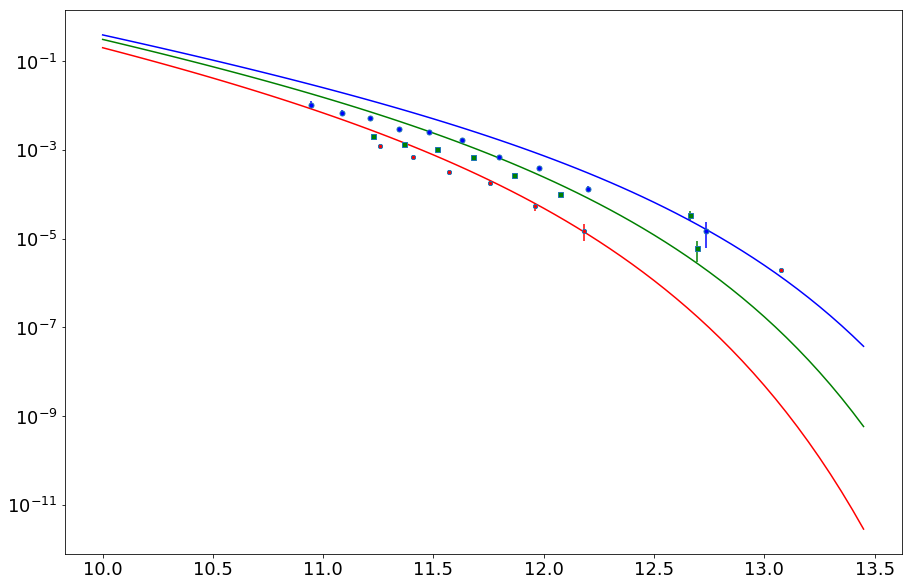

In [135]:
bz4 = conv_uvsm_behroozi(4)
bz5 = conv_uvsm_behroozi(5)
bz6 = conv_uvsm_behroozi(6)

plt.figure(figsize=(15,10))

plt.errorbar(bz4.Mh,bz4.phi,yerr=bz4.err_phi,marker='o',ms=5, mfc='b',ecolor="b",linestyle="")
plt.errorbar(bz5.Mh,bz5.phi ,yerr=bz5.err_phi,marker='s',ms=5, mfc='g',ecolor="g",linestyle="")
plt.errorbar(bz6.Mh,bz6.phi ,yerr=bz6.err_phi,marker='8',ms=5, mfc='r',ecolor="r",linestyle="")
color = ['b','g','r']
color2 = ['b--','g--','r--']
hmf_um = [hmf_z4,hmf_z5,hmf_z6]
for i in range(3):
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i])
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])
    '''
#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')

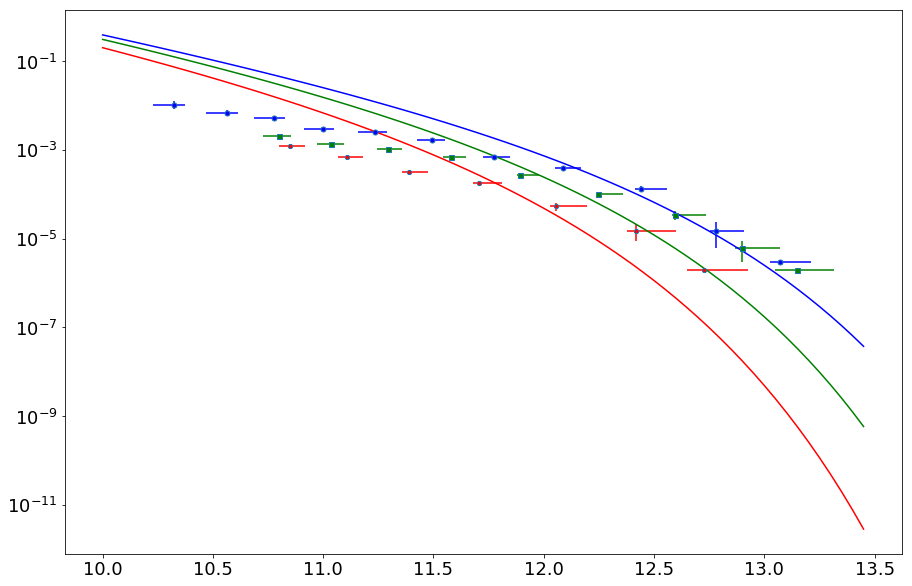

In [141]:
sfr = 0.4
fb = 0.016 * sfr
bz4 = conv_uvsm_sfr1(4,fb)
bz5 = conv_uvsm_sfr1(5,fb)
bz6 = conv_uvsm_sfr1(6,fb)

plt.figure(figsize=(15,10))

plt.errorbar(bz4.Mh,bz4.phi, xerr=[bz4.Mh_B-bz4.Mh, bz4.Mh-bz4.Mh_b] ,yerr=bz4.err_phi,marker='o',ms=5, mfc='b',ecolor="b",linestyle="")
plt.errorbar(bz5.Mh,bz5.phi, xerr=[bz5.Mh_B-bz5.Mh, bz5.Mh-bz5.Mh_b] ,yerr=bz5.err_phi,marker='s',ms=5, mfc='g',ecolor="g",linestyle="")
plt.errorbar(bz6.Mh,bz6.phi, xerr=[bz6.Mh_B-bz6.Mh, bz6.Mh-bz6.Mh_b] ,yerr=bz6.err_phi,marker='8',ms=5, mfc='r',ecolor="r",linestyle="")
color = ['b','g','r']
color2 = ['b--','g--','r--']
hmf_um = [hmf_z4,hmf_z5,hmf_z6]
for i in range(3):
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i])
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])
    '''
#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')